In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, ConcatDataset
import random
from sklearn.metrics import classification_report

# Cấu hình thiết bị
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Torch empty cache
torch.cuda.empty_cache()

Using device: cuda


Tiền Xử Lý và Nạp Dataset

In [2]:
# Tiền xử lý dữ liệu hình ảnh
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
full_dataset = datasets.ImageFolder("./data/Final_CLD_data/val", transform)
rare_dataset = datasets.ImageFolder("./data/Fewshot_rare_data/train", transform)

# Offset labels cho rare dataset để tránh trùng lặp
rare_dataset.samples = [(path, label + 5) for path, label in rare_dataset.samples]

# Kết hợp datasets
combined_dataset = ConcatDataset([full_dataset, rare_dataset])

# Mapping class indices
def get_class_indices(dataset):
    indices = {}
    for idx, (_, label) in enumerate(dataset):
        indices.setdefault(label, []).append(idx)
    return indices

class_indices = get_class_indices(combined_dataset)

# Kiểm tra số lượng mẫu mỗi lớp
for cls, idxs in class_indices.items():
    print(f"Class {cls}: {len(idxs)} samples")


Class 0: 5000 samples
Class 1: 5000 samples
Class 2: 5000 samples
Class 3: 5000 samples
Class 4: 5000 samples
Class 5: 20 samples
Class 6: 20 samples


 Khởi Tạo và Load Model EfficientNet

In [3]:
model = models.efficientnet_b0(weights=None)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 5)
model.load_state_dict(torch.load("./model/efficientnet_coffee.pth"))

# Loại bỏ classifier để chỉ lấy embeddings
model.classifier[1] = nn.Identity()
model = model.to(DEVICE).eval()

print("✅ EfficientNet feature extractor loaded successfully!")

def create_episode(dataset, class_indices, n_way=7, n_shot=5, n_query=5):
    selected_classes = random.sample(list(class_indices.keys()), n_way)
    support_imgs, query_imgs, support_labels, query_labels = [], [], [], []

    for new_label, class_id in enumerate(selected_classes):
        indices = class_indices[class_id]
        if len(indices) < n_shot + n_query:
            continue
        sampled_indices = random.sample(indices, n_shot + n_query)
        support_imgs += [dataset[i][0] for i in sampled_indices[:n_shot]]
        query_imgs += [dataset[i][0] for i in sampled_indices[n_shot:]]
        support_labels += [new_label] * n_shot
        query_labels += [new_label] * n_query

    return (torch.stack(support_imgs).to(DEVICE),
            torch.tensor(support_labels).to(DEVICE),
            torch.stack(query_imgs).to(DEVICE),
            torch.tensor(query_labels).to(DEVICE))

def proto_loss(support, query, n_way, n_shot, n_query):
    prototypes = support.view(n_way, n_shot, -1).mean(dim=1)
    distances = torch.cdist(query, prototypes)
    labels = torch.arange(n_way).repeat_interleave(n_query).to(DEVICE)
    return F.cross_entropy(-distances, labels)

def calculate_prototypes(model, loader):
    model.eval()
    embeddings, labels = [], []
    with torch.no_grad():
        for imgs, labs in loader:
            imgs = imgs.to(DEVICE)
            emb = model(imgs)
            embeddings.append(emb.cpu())
            labels.append(labs)
    embeddings = torch.cat(embeddings)
    labels = torch.cat(labels)

    prototypes = []
    for label in range(7):  # Xác nhận đủ 7 lớp
        class_emb = embeddings[labels == label]
        prototypes.append(class_emb.mean(dim=0) if len(class_emb) > 0 else torch.zeros(embeddings[0].shape))
    return torch.stack(prototypes).to(DEVICE)



✅ EfficientNet feature extractor loaded successfully!


Fine-tuning Model

In [4]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
n_epochs, episodes_per_epoch, n_way, n_shot, n_query = 10, 20, 7, 5, 5

model.train()
for epoch in range(n_epochs):
    total_loss, total_correct, total_samples = 0, 0, 0

    for _ in range(episodes_per_epoch):
        s_imgs, s_labels, q_imgs, q_labels = create_episode(combined_dataset, class_indices, n_way, n_shot, n_query)
        s_emb, q_emb = model(s_imgs), model(q_imgs)

        loss = proto_loss(s_emb, q_emb, n_way, n_shot, n_query)

        # Accuracy Calculation
        prototypes = s_emb.view(n_way, n_shot, -1).mean(dim=1)
        distances = torch.cdist(q_emb, prototypes)
        preds = torch.argmin(distances, dim=1)
        total_correct += (preds == q_labels).sum().item()
        total_samples += q_labels.size(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {total_loss/episodes_per_epoch:.4f}, Accuracy: {total_correct/total_samples*100:.2f}%")


Epoch [1/10], Loss: 0.1984, Accuracy: 93.43%
Epoch [2/10], Loss: 0.0287, Accuracy: 98.86%
Epoch [3/10], Loss: 0.0094, Accuracy: 99.86%
Epoch [4/10], Loss: 0.0073, Accuracy: 99.86%
Epoch [5/10], Loss: 0.0058, Accuracy: 99.86%
Epoch [6/10], Loss: 0.0167, Accuracy: 99.71%
Epoch [7/10], Loss: 0.0093, Accuracy: 99.71%
Epoch [8/10], Loss: 0.0044, Accuracy: 99.86%
Epoch [9/10], Loss: 0.0014, Accuracy: 100.00%
Epoch [10/10], Loss: 0.0034, Accuracy: 100.00%


6. Tính Lại Prototypes và Đánh Giá Model

In [5]:
# Tính lại prototypes sau fine-tuning
# load ./model/efficientnet_10shot_20episode.pth
# model.load_state_dict(torch.load("./model/efficientnet_10shot_20episode.pth"))
train_loader = DataLoader(combined_dataset, batch_size=32, shuffle=False)
prototypes = calculate_prototypes(model, train_loader)
print("✅ Prototypes recalculated successfully!")

# Đánh giá trên tập test
test_dataset = datasets.ImageFolder("./data/full_data_for_fewshot", transform)
rare_test_dataset = datasets.ImageFolder("./data/Fewshot_rare_data/test", transform)
rare_test_dataset.samples = [(path, label + 5) for path, label in rare_test_dataset.samples]

combined_test_dataset = ConcatDataset([test_dataset, rare_test_dataset])
test_loader = DataLoader(combined_test_dataset, batch_size=32, shuffle=False)

true_labels, pred_labels = [], []

model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE)
        embeddings = model(imgs)
        distances = torch.cdist(embeddings, prototypes)
        preds = torch.argmin(distances, dim=1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

report = classification_report(true_labels, pred_labels, target_names=[
    'Cerscospora', 'Healthy', 'Leaf rust', 'Miner', 'Phoma', 'Nematode', 'Pink disease'], zero_division=1)

print(report)

def plot_confusion_matrix(true_labels, pred_labels, class_names):
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix")
    plt.show()

✅ Prototypes recalculated successfully!
              precision    recall  f1-score   support

 Cerscospora       0.98      1.00      0.99       300
     Healthy       1.00      1.00      1.00       300
   Leaf rust       1.00      1.00      1.00       300
       Miner       0.96      1.00      0.98       300
       Phoma       0.89      1.00      0.94       300
    Nematode       0.94      0.75      0.84       163
Pink disease       0.98      0.90      0.94       271

    accuracy                           0.96      1934
   macro avg       0.96      0.95      0.95      1934
weighted avg       0.97      0.96      0.96      1934



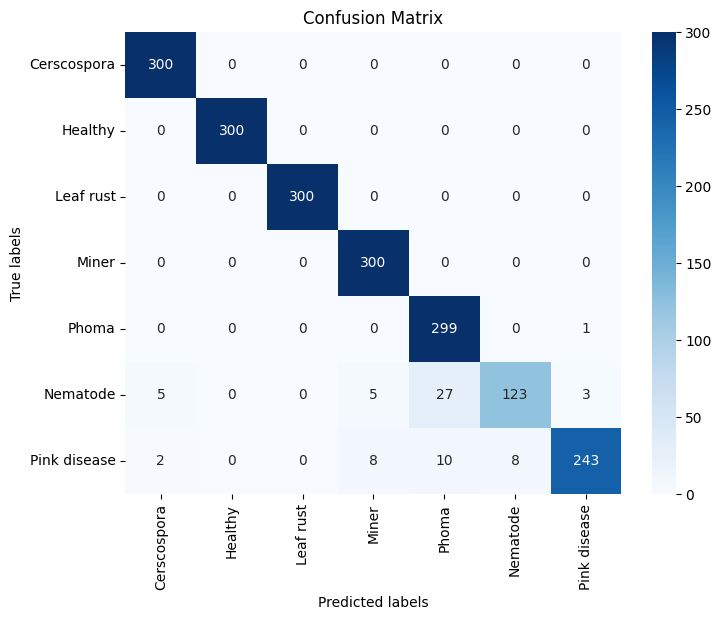

In [6]:
plot_confusion_matrix(true_labels, pred_labels, [
    'Cerscospora', 'Healthy', 'Leaf rust', 'Miner', 'Phoma', 'Nematode', 'Pink disease'])